In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-Processing

In [3]:
class_names = ['1Rand 1', '1Rand 2', '2Rand 1', '2Rand 2', '5Rand 1', '5Rand 2',
               '5Rand 3', '5Rand 4', '5Rand 5', '10cents 1'
              , '10cents 2', '20cents 1', '20cents 2', '50cents 1', '50cents 2']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
epochs = 20
IMAGE_SIZE = (150, 150)

In [4]:
def load_data(split_ratio=0.8):
    """
    Load the data and split it into training and testing sets.
    """
    dataset_dir = '/content/drive/MyDrive/Comp702Project/south_african_coins33'
    output = []

    images = []
    labels = []

    print("Loading {}".format(dataset_dir))

    # Iterate through each folder corresponding to a category
    for folder in os.listdir(dataset_dir):
        label = class_names_label[folder]

        # Iterate through each image in the folder
        for file in tqdm(os.listdir(os.path.join(dataset_dir, folder))):
            # Get the path of the image
            img_path = os.path.join(os.path.join(dataset_dir, folder), file)

            # Open and resize the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    # Split the data into training and testing sets
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=split_ratio, random_state=42)

    output.append((train_images, train_labels))
    output.append((test_images, test_labels))

    return output

In [5]:
(train_images, train_labels) = load_data()[0]
(test_images, test_labels) = load_data()[1]

Loading /content/drive/MyDrive/Comp702Project/south_african_coins33


100%|██████████| 104/104 [00:03<00:00, 28.22it/s]


Loading /content/drive/MyDrive/Comp702Project/south_african_coins33


100%|██████████| 104/104 [00:00<00:00, 188.85it/s]


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 738
Number of testing examples: 185
Each image is of size: (150, 150)


In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [10]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [11]:
def plotConfusionMatrix(test_labels, pred_labels):
    CM = confusion_matrix(test_labels, pred_labels)
    ax = plt.axes()
    sn.heatmap(CM, annot=True,
               annot_kws={"size": 10},
               xticklabels=class_names,
               yticklabels=class_names, ax = ax)
    ax.set_title('Confusion matrix')
    plt.show()

In [12]:
def getTrainingScores(train_predictions, train_labels ):
    # Convert the predicted probabilities to binary predictions
    pred_labels = np.argmax(train_predictions, axis=1)

    # Calculate the metrics
    accuracy_train = accuracy_score(train_labels, pred_labels)
    precision_train = precision_score(train_labels, pred_labels, average='weighted', zero_division=0)
    recall_train = recall_score(train_labels, pred_labels, average='weighted')
    f1_train = f1_score(train_labels, pred_labels, average='weighted')

    # Print the metrics for the testing set
    print("................Training set scores..............................")
    print("Training set accuracy:", accuracy_train)
    print("Training set precision:", precision_train)
    print("Training set recall:", recall_train)
    print("Training set F1 score:", f1_train)



def getTestScore(test_predictions, test_labels):
    # Convert the predicted probabilities to binary predictions
    pred_labels = np.argmax(test_predictions, axis=1)

    # Calculate the metrics
    accuracy_test = accuracy_score(test_labels, pred_labels)
    precision_test = precision_score(test_labels, pred_labels, average='weighted', zero_division=0)
    recall_test = recall_score(test_labels, pred_labels, average='weighted')
    f1_test = f1_score(test_labels, pred_labels, average='weighted')

    # Print the metrics for the testing set
    print("................Testing set scores..............................")
    print("Testing set accuracy:", accuracy_test)
    print("Testing set precision:", precision_test)
    print("Testing set recall:", recall_test)
    print("Testing set F1 score:", f1_test)


In [13]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

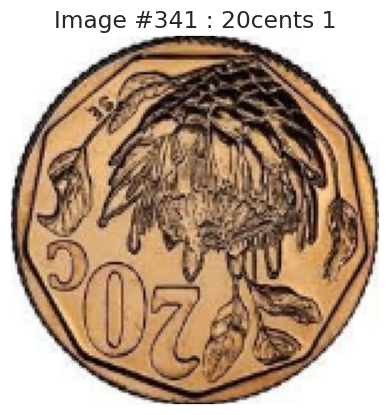

In [14]:
display_random_image(class_names, train_images, train_labels)

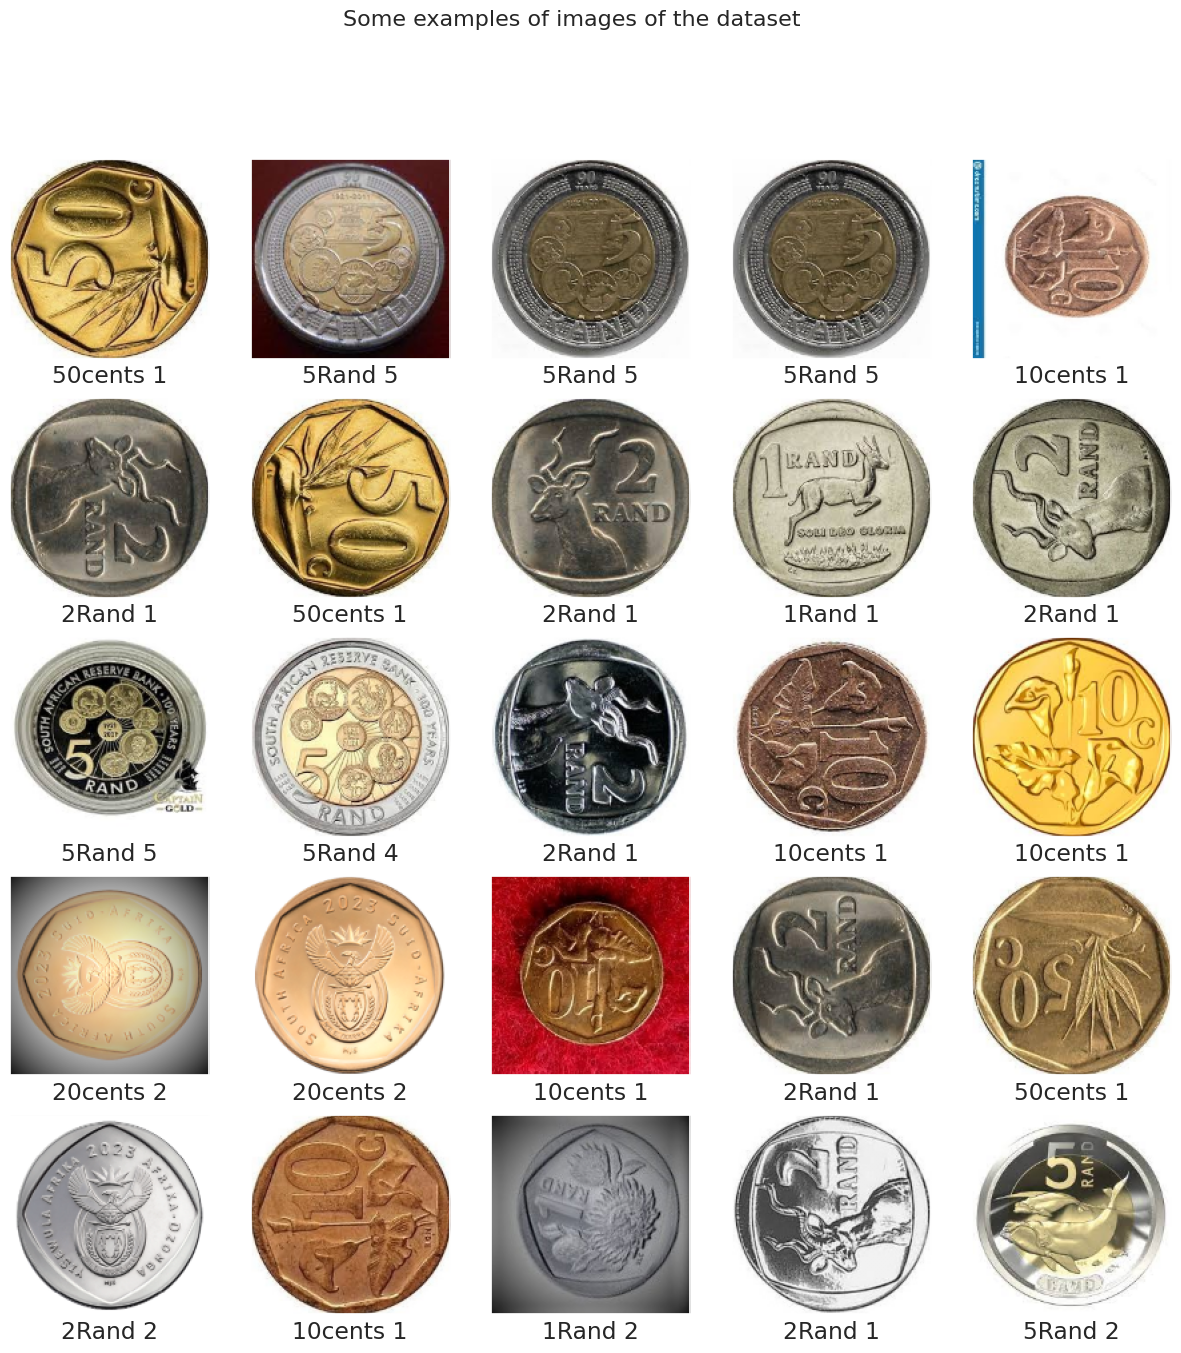

In [15]:
display_examples(class_names, train_images, train_labels)

## CNN Model

In [16]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])

In [17]:
model_cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_cnn = ModelCheckpoint('best_cnn_weights.h5', monitor='val_loss', save_best_only=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 flatten (Flatten)           (None, 700928)            0         
                                                                 
 dense (Dense)               (None, 15)                10513935  
                                                                 
Total params: 10,514,831
Trainable params: 10,514,831
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model_cnn.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_split = 0.2,callbacks=[early_stopping, model_checkpoint_cnn])

Epoch 1/20
5/5 [==============================] - 13s 3s/step - loss: 87.2909 - accuracy: 0.0881 - val_loss: 115.3478 - val_accuracy: 0.1014
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 102.8094 - accuracy: 0.1068 - val_loss: 81.8922 - val_accuracy: 0.0541
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 52.2790 - accuracy: 0.1661 - val_loss: 41.2046 - val_accuracy: 0.1149
Epoch 4/20
5/5 [==============================] - 12s 2s/step - loss: 21.1063 - accuracy: 0.2458 - val_loss: 12.1050 - val_accuracy: 0.2365
Epoch 5/20
5/5 [==============================] - 11s 2s/step - loss: 7.0612 - accuracy: 0.3610 - val_loss: 4.6084 - val_accuracy: 0.4527
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 1.9821 - accuracy: 0.6864 - val_loss: 2.2992 - val_accuracy: 0.5068
Epoch 7/20
5/5 [==============================] - 11s 2s/step - loss: 1.1458 - accuracy: 0.7780 - val_loss: 1.6276 - val_accuracy: 0.5946
Epoch 8/20
5/5 [=========

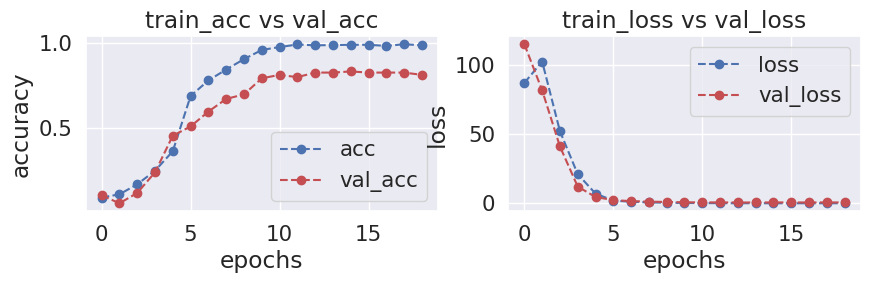

In [19]:
plot_accuracy_loss(history)

In [20]:
test_loss = model_cnn.evaluate(test_images, test_labels)

6/6 [==============================] - 3s 531ms/step - loss: 0.6257 - accuracy: 0.8054


6/6 [==============================] - 2s 320ms/step


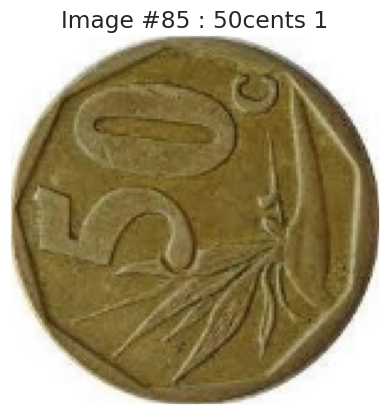

In [21]:
predictions = model_cnn.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels)

In [22]:
getTestScore(predictions, test_labels)

................Testing set scores..............................
Testing set accuracy: 0.8054054054054054
Testing set precision: 0.8291367687919413
Testing set recall: 0.8054054054054054
Testing set F1 score: 0.8016233734032787


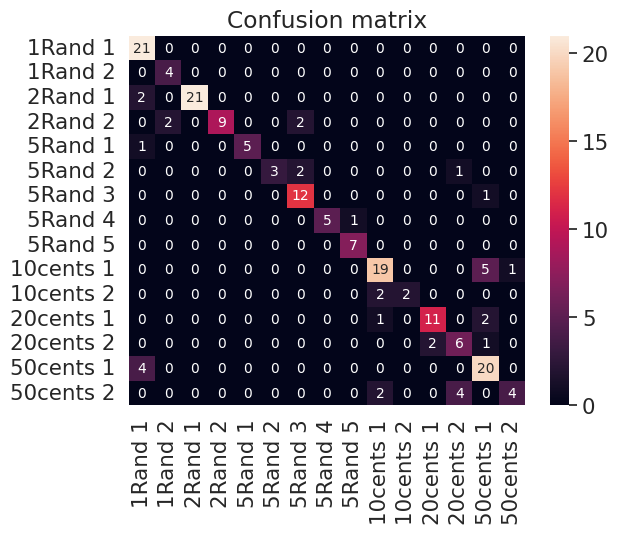

In [23]:
plotConfusionMatrix(test_labels, pred_labels)

24/24 [==============================] - 8s 313ms/step


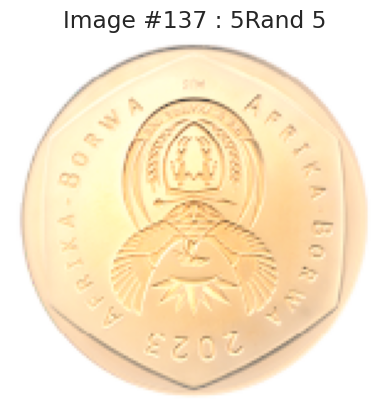

In [24]:
predictions = model_cnn.predict(train_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels)

In [25]:
getTrainingScores(predictions, train_labels)

................Training set scores..............................
Training set accuracy: 0.9579945799457995
Training set precision: 0.9589601587901313
Training set recall: 0.9579945799457995
Training set F1 score: 0.9575893264871281


## Lenet5 Model

In [26]:
model_lenet5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])
model_lenet5.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model_lenet5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 73984)             0         
                                                                 
 dense_1 (Dense)             (None, 120)              

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_lenet5 = ModelCheckpoint('best_lstm_weights.h5', monitor='val_loss', save_best_only=True)

history_lenet5 = model_lenet5.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_split = 0.2,callbacks=[early_stopping, model_checkpoint_lenet5])

Epoch 1/20
5/5 [==============================] - 45s 9s/step - loss: 5.0467 - accuracy: 0.0780 - val_loss: 2.6857 - val_accuracy: 0.0811
Epoch 2/20
5/5 [==============================] - 42s 8s/step - loss: 2.5503 - accuracy: 0.1949 - val_loss: 2.7567 - val_accuracy: 0.1757
Epoch 3/20
5/5 [==============================] - 49s 9s/step - loss: 2.3859 - accuracy: 0.2610 - val_loss: 2.3151 - val_accuracy: 0.2297
Epoch 4/20
5/5 [==============================] - 42s 8s/step - loss: 2.0811 - accuracy: 0.3203 - val_loss: 2.0894 - val_accuracy: 0.2973
Epoch 5/20
5/5 [==============================] - 43s 8s/step - loss: 1.8217 - accuracy: 0.4051 - val_loss: 1.8057 - val_accuracy: 0.4324
Epoch 6/20
5/5 [==============================] - 42s 8s/step - loss: 1.5484 - accuracy: 0.5034 - val_loss: 1.4963 - val_accuracy: 0.4595
Epoch 7/20
5/5 [==============================] - 43s 9s/step - loss: 1.2060 - accuracy: 0.6220 - val_loss: 1.1805 - val_accuracy: 0.6216
Epoch 8/20
5/5 [==================

In [29]:
test_loss = model_lenet5.evaluate(test_images, test_labels)

6/6 [==============================] - 3s 448ms/step - loss: 0.4664 - accuracy: 0.8595


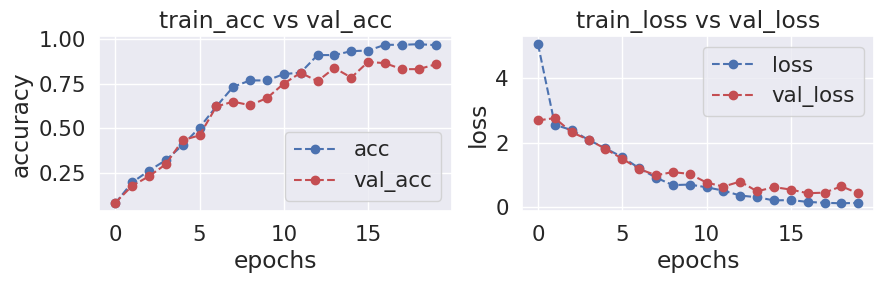

In [30]:
plot_accuracy_loss(history_lenet5)

6/6 [==============================] - 4s 603ms/step


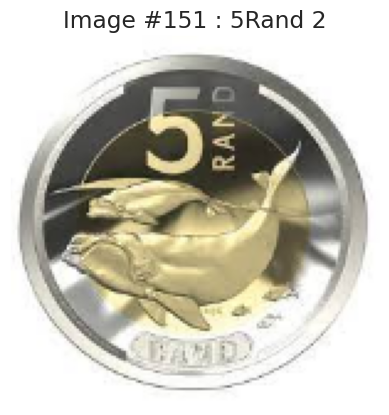

In [31]:
predictions = model_lenet5.predict(test_images)     # Vector of probabilities
pred_labels_2 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_2)

In [32]:
getTestScore(predictions, test_labels)

................Testing set scores..............................
Testing set accuracy: 0.8594594594594595
Testing set precision: 0.889081939081939
Testing set recall: 0.8594594594594595
Testing set F1 score: 0.861221097733293


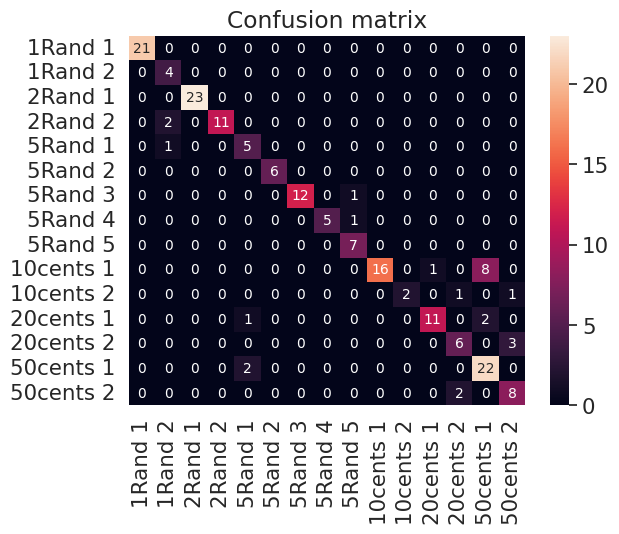

In [33]:
plotConfusionMatrix(test_labels, pred_labels_2)

24/24 [==============================] - 14s 571ms/step


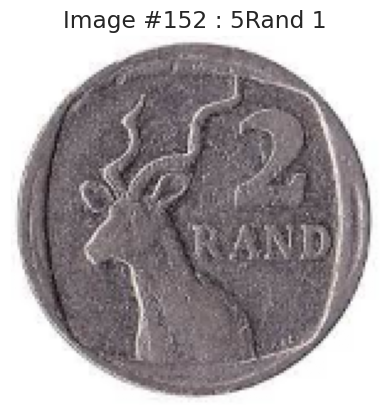

In [34]:
predictions =model_lenet5.predict(train_images)     # Vector of probabilities
pred_labels_2 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_2)

In [35]:
getTrainingScores(predictions, train_labels)

................Training set scores..............................
Training set accuracy: 0.9471544715447154
Training set precision: 0.9498416325230722
Training set recall: 0.9471544715447154
Training set F1 score: 0.9475152153361959


## RNN Model

In [36]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Reshape((150, 150 * 3), input_shape=(150, 150, 3)),
    tf.keras.layers.SimpleRNN(128, activation='relu'),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])

model_rnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 150, 450)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               74112     
                                                                 
 dense_4 (Dense)             (None, 15)                1935      
                                                                 
Total params: 76,047
Trainable params: 76,047
Non-trainable params: 0
_________________________________________________________________


In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_rnn = ModelCheckpoint('best_cnn_weights.h5', monitor='val_loss', save_best_only=True)
history_rnn = model_rnn.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_split = 0.2,callbacks=[early_stopping, model_checkpoint_rnn])

Epoch 1/20
5/5 [==============================] - 3s 379ms/step - loss: 3.0074 - accuracy: 0.1102 - val_loss: 2.9167 - val_accuracy: 0.1216
Epoch 2/20
5/5 [==============================] - 1s 261ms/step - loss: 2.7053 - accuracy: 0.1136 - val_loss: 2.6690 - val_accuracy: 0.1081
Epoch 3/20
5/5 [==============================] - 1s 262ms/step - loss: 2.6033 - accuracy: 0.1475 - val_loss: 2.6469 - val_accuracy: 0.1216
Epoch 4/20
5/5 [==============================] - 1s 258ms/step - loss: 2.5572 - accuracy: 0.1763 - val_loss: 2.6137 - val_accuracy: 0.1284
Epoch 5/20
5/5 [==============================] - 2s 455ms/step - loss: 2.5282 - accuracy: 0.1407 - val_loss: 2.6008 - val_accuracy: 0.1216
Epoch 6/20
5/5 [==============================] - 2s 454ms/step - loss: 2.5097 - accuracy: 0.1847 - val_loss: 2.5994 - val_accuracy: 0.1081
Epoch 7/20
5/5 [==============================] - 1s 262ms/step - loss: 2.4736 - accuracy: 0.1746 - val_loss: 2.5650 - val_accuracy: 0.1486
Epoch 8/20
5/5 [====

In [39]:
test_loss = model_rnn.evaluate(test_images, test_labels)

6/6 [==============================] - 0s 53ms/step - loss: 2.4435 - accuracy: 0.2054


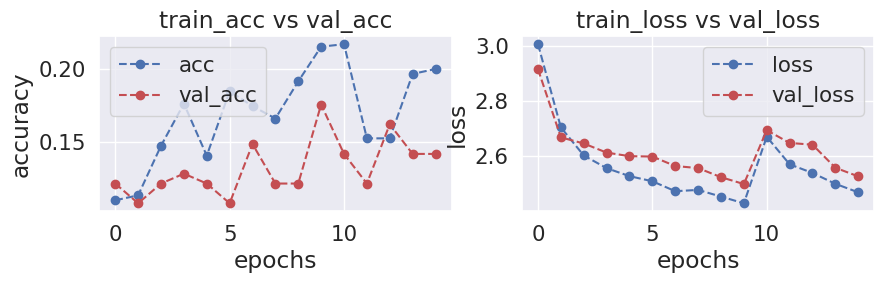

In [40]:
plot_accuracy_loss(history_rnn)

6/6 [==============================] - 0s 30ms/step


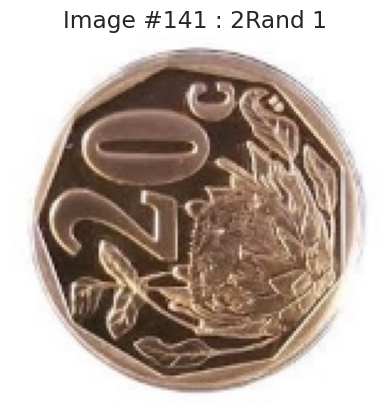

In [41]:
predictions = model_rnn.predict(test_images)     # Vector of probabilities
pred_labels_3 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_3)

In [42]:
getTestScore(predictions, test_labels)

................Testing set scores..............................
Testing set accuracy: 0.20540540540540542
Testing set precision: 0.2855135135135135
Testing set recall: 0.20540540540540542
Testing set F1 score: 0.1430666479734803


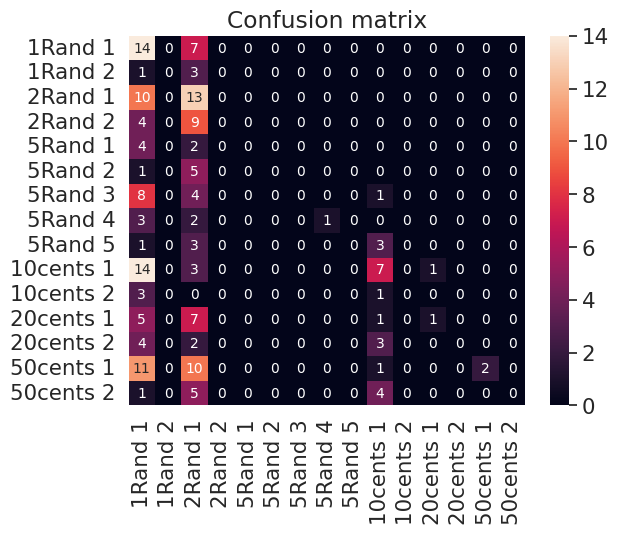

In [43]:
plotConfusionMatrix(test_labels, pred_labels_3)

24/24 [==============================] - 1s 33ms/step


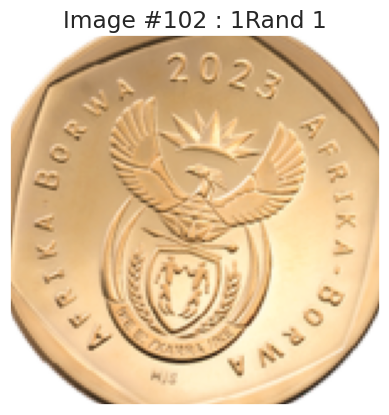

In [44]:
predictions = model_rnn.predict(train_images)     # Vector of probabilities
pred_labels_3 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_3)

In [45]:
getTrainingScores(predictions, train_labels)

................Training set scores..............................
Training set accuracy: 0.23035230352303523
Training set precision: 0.3247689755608857
Training set recall: 0.23035230352303523
Training set F1 score: 0.15491462312426
